In [1]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from collections import namedtuple
from numpy import nan
from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score


In [12]:
# with location metadata:

new_metadata = pd.read_csv(
    "../data/metadata/CMS001_CMS002_MergedAnnotations.csv", 
    header = 0, 
)

species_id = new_metadata[[
    "czbiohub-mosquito_sequences_id",
    "visual_genus", 
    "visual_species", 
    "sourmash_species", 
    "sourmash_genus"
]]

species_id.rename(
    columns = {
        'compute_species': 'sourmash_species',
        'compute_genus': 'sourmash_genus',
        'czbiohub-mosquito_sequences_id': ''
    }, 
    inplace = True
)
species_id.set_index("", inplace=True)

len(species_id) # 161
species_id.head()


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,visual_genus,visual_species,sourmash_species,sourmash_genus
,,,,
CMS_001_RNA_A_S1,Culex,erythrothorax,erythrothorax,Culex
CMS_002_RNA_A_S1,Culex,tarsalis,tarsalis,Culex
CMS_003_RNA_A_S2,Culiseta,particeps,particeps,Culiseta
CMS_004_RNA_A_S2,Culex,pipiens,pipiens,Culex
CMS_005_RNA_A_S3,Culiseta,incidens,incidens,Culiseta


In [13]:
def clean_data(dd_tsv, tailing, metadata):
    '''
    clean data and remove water samples
    '''
    
    # read in data tables with sample distances computed with ska (split kmer analysis)
    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")
    
    # Add prefix columns and size
    dd_tsv["Sample_1"] = dd_tsv.apply(lambda row: row["Sample_1"].split(tailing)[0], axis=1)
    dd_tsv["Sample_2"] = dd_tsv.apply(lambda row: row["Sample_2"].split(tailing)[0], axis=1)

    # re-organize columns
    dd_tsv = dd_tsv[["Sample_1", 
                     "Sample_2", 
                     "Matches", 
                     "Mismatches", 
                     "Jaccard_Index",
                     "Mash-like_distance",
                     "SNPs",
                     "SNP_distance",
                    ]]
    
    return dd_tsv


def create_pivot(df, values="SNP_distance", diagonal=0):    
    ''' create pivot tables with sample 1 and sample 2 correlations'''
    
    dd_tsv_pivot = df.pivot(
        columns="Sample_1", 
        index="Sample_2", 
        values=values
    )
    dd_tsv_pivot = dd_tsv_pivot.loc[dd_tsv_pivot.columns, :]
    np.fill_diagonal(dd_tsv_pivot.values, diagonal)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())
    return dd_tsv_pivot


def add_metadata_to_pivot(df, metadata_fields, metadata):
    """join metadata onto pivot table for axis labeling"""
    
    dd_tsv_pivot_w_labels = pd.merge(
        df.reset_index(), 
        metadata[metadata_fields], 
        how='left',
        left_on="Sample_1", 
        right_index=True, 
    ).reset_index().set_index(
        ["Sample_1"] + metadata_fields
    ).drop(["index"], axis=1)
    
    return dd_tsv_pivot_w_labels


def get_linkage(pivot_df):
    '''clustering linkage'''
    
    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters, extra=True):
    """cluster distance matrix and re-assign species as cluster species mode"""
    
    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    cluster_map = pd.DataFrame()
    
    if extra:
        cluster_map['visual_genus'] = pivot_df.index.get_level_values(1)
        cluster_map['visual_species'] = pivot_df.index.get_level_values(2)
        cluster_map['sourmash_genus'] = pivot_df.index.get_level_values(3)
        cluster_map['sourmash_species'] = pivot_df.index.get_level_values(4)
        
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    cluster_chunks = []
    for clust in cluster_map.cluster.unique():
        subset = cluster_map[cluster_map.cluster == clust]
        species_mode = subset.visual_species.mode()[0]
        genus_mode = subset[subset["visual_species"] == species_mode].visual_genus.values[0]
        subset["ska_species"] = species_mode
        subset["ska_genus"] = genus_mode
        cluster_chunks.append(subset)

    cluster_map_w_ska = pd.concat(cluster_chunks)
    return cluster_map_w_ska



def join_on_ska_labels(fp, metadata, tailing, k, values="SNP_distance"):
    '''read in fp and create pivot distance matrix with old and new species labels'''
    
    df_cleaned = clean_data(
        fp, 
        metadata=metadata,
        tailing=tailing
    )

    dd_pivot = create_pivot(
        df_cleaned, 
        values=values, 
        diagonal=0
    )

    metadata_fields = [
        "visual_genus", 
        "visual_species", 
        "sourmash_genus",
        "sourmash_species"
    ]

    dd_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        metadata_fields, 
        metadata=metadata
    )

    linkage = get_linkage(dd_pivot)

    cluster_map = get_cluster_map(
        dd_pivot_w_labels, 
        linkage, 
        k, 
        extra=True
    )

    ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

    final_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        ska_metadata_fields, 
        metadata=cluster_map
    )
    
    return final_pivot_w_labels, cluster_map, linkage


def wrap_clustermap_and_mismatches(fp, metadata, tailing, k=10, figsize=(60,60), values="SNP_distance", diagonal=0):
    '''create clustermap with new and old species assigned labels'''
    
    dd_pivot_w_ska_labels, cluster_map, linkage = join_on_ska_labels(
        fp, 
        metadata, 
        tailing,
        k,
        values=values
    )
    
    c = correlation_matrix(
        dd_pivot_w_ska_labels, 
        linkage, 
        cluster_map, 
        figsize=(60,60)
    )
    
    return dd_pivot_w_ska_labels.query(
        'visual_species != sourmash_species | ' + 
        'visual_species != ska_species | ' + 
        'sourmash_species != ska_species'
    )


def hierarchical_clustering(dd_pivot_w_ska_labels, metadata, tailing, k, values="SNP_distance"):
    
    cdist = scipy.spatial.distance.squareform(dd_pivot_w_ska_labels)
    Z = shc.linkage(cdist, method="ward")
    fig = plt.figure(figsize=(25, 10))
    
    dn = shc.dendrogram(
        Z, 
        leaf_font_size=8, 
        labels=dd_pivot_w_ska_labels.index.get_level_values(6), 
        color_threshold=0.008
    )
    
    return dn


def get_silhouette_score(pivot_df, metadata, tailing, values="SNP_distance", correlation=False):
    '''use silhouette metric to see how compact and distinct clusters are '''

    cdist = scipy.spatial.distance.squareform(pivot_df)  
    linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")
    clusters = fcluster(linkage, 10, criterion='maxclust')
    
    cluster_map = pd.DataFrame()
    
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)
    
    return silhouette_score(pivot_df, metric="precomputed", labels=cluster_map["cluster"])


def correlation_matrix(pivot_w_labels, linkage, cluster_map, figsize=(60,60)):
    '''correlatian matrix comparing visual, sourmash, and ska species assignment'''
       
    species_coloring = {
         'Pipiens': "#4c72a5",
         'Erythrothorax': "#48a365",
         'Quinquefasciatus': "#77bedb",
         'Tarsalis': "#90ce9b",

         'Aegypti': "#ccc197",
         'Particeps': "#ba8b07",
         'Albopictus': "#e1c72f",

         'Incidens': "#d0694a",
         'Dorsalis': "#cc79a7",
         'Inornata': "#7f6e85",
         np.NaN: "#E5E5E5"
    }

    legend_labeling = {
         'Culex Pipiens': "#4c72a5",
         'Culex Erythrothorax': "#48a365",
         'Culex Quinquefasciatus': "#77bedb",
         'Culex Tarsalis': "#90ce9b",

         'Aedes Aegypti': "#ccc197",
         'Aedes Particeps': "#ba8b07",
         'Aedes Albopictus': "#e1c72f",

         'Culiseta Incidens': "#d0694a",
         'Culiseta Dorsalis': "#cc79a7",
         'Culiseta Inornata': "#7f6e85",
         'No Label': "#E5E5E5"
    }
    

    pivot_index = pivot_w_labels.reset_index()
    pivot_index['visual_species'] = pivot_index['visual_species'].str.capitalize() 
    pivot_index['ska_species'] = pivot_index['ska_species'].str.capitalize() 

    key_colors_original = pivot_index["visual_species"].map(species_coloring)
    key_colors_ska = pivot_index["ska_species"].map(species_coloring)

    key_colors_labels = pd.DataFrame.from_dict(
        {
            "index": pivot_index["Sample_1"].values,
            "Original": key_colors_original, 
            "Corrected": key_colors_ska
        }
    ).set_index("index")
    
    legend_patches = [
        mpatches.Patch(
            color=c, label=sp
        ) 
        for sp,c in legend_labeling.items()
    ]

    c = sns.clustermap(
            pivot_w_labels.reset_index().drop([
                "visual_genus", 
                "visual_species", 
                "sourmash_genus",
                "sourmash_species",
                "ska_genus",
                "ska_species"
            ], axis=1).set_index("Sample_1"),
            metric="correlation", 
            cmap="mako",
            row_colors=key_colors_labels, 
            col_colors=key_colors_labels,
            figsize=figsize,
            col_linkage=linkage,
            row_linkage=linkage,
            xticklabels=pivot_w_labels.index.get_level_values(0),
            yticklabels=pivot_w_labels.index.get_level_values(6).str.capitalize()
    )
    c.cax.set_visible(False)
    ax = c.ax_heatmap
    ax.set_xlabel("")
    ax.set_ylabel("")
    l=c.ax_heatmap.legend(
        loc='upper left',
        bbox_to_anchor=(1.04, 1.015),
        handles=legend_patches,
        frameon=False,
        fontsize=55
    )
#     l2.set_title(title='species',prop={'size':20})

    return c, l


In [14]:
t_raw = pd.read_csv("ksize_15_11_25_19.distances.tsv", sep="\t")

# remove water samples
t_raw_no_water = t_raw[
    ~(
        (t_raw["Sample 1"].str.contains("ater")) |
        (t_raw["Sample 2"].str.contains("ater"))
    )
]
t_raw_no_water

uniques_sample_1 = [y.split("_ksize_15")[0] for y in t_raw_no_water["Sample 1"].unique()] 
uniques_sample_2 = [y.split("_ksize_15")[0] for y in t_raw_no_water["Sample 2"].unique()]
    
# count in both samples 1 and 2 for some non-repeated data
[x for x in species_id.index if x not in uniques_sample_1 + uniques_sample_2]


t_raw_no_water[t_raw_no_water["Sample 1"].str.contains('CMS_002_17a_Rb_S122_L004')]
t_raw_cleaned = clean_data(t_raw, "_ksize_15", species_id)
t_raw_piv = create_pivot(t_raw_cleaned)
t_raw_piv_no_waters = t_raw_piv[~(t_raw_piv.index.str.contains("ater"))]
t_raw_piv_no_waters_col = t_raw_piv_no_waters.drop(
    columns=t_raw_piv_no_waters.columns[t_raw_piv_no_waters.columns.str.contains("ater")].to_list()
)

# check for missing samples:
print([x for x in species_id.index if x not in t_raw_piv_no_waters_col.index])



[]


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [15]:

metadata_fields = [
    "visual_genus", 
    "visual_species", 
    "sourmash_genus",
    "sourmash_species"
]

dd_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv_no_waters_col, 
    metadata_fields, 
    metadata=species_id
)

linkage = get_linkage(t_raw_piv_no_waters_col)

cluster_map = get_cluster_map(
    dd_pivot_w_labels, 
    linkage, 
    10, 
    extra=True
)

ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

final_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv_no_waters_col, 
    ska_metadata_fields, 
    metadata=cluster_map
)


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,,,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,visual_genus,visual_species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.001703,0.001656,0.006803,0.006993,0.007157,0.007046,0.007164,0.006995,...,0.002589,0.000000,0.000120,0.002081,0.000000,0.000000,0.000118,0.000000,0.002072,0.006644
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex,pipiens,0.002093,0.003095,0.000204,0.000407,0.006417,0.006431,0.006743,0.006680,0.006132,0.006680,...,0.002444,0.001779,0.001892,0.000281,0.001894,0.001622,0.003295,0.002487,0.000456,0.006027
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens,0.007397,0.007382,0.006635,0.007339,0.006987,0.007747,0.007251,0.007909,0.007351,0.006858,...,0.007307,0.006660,0.006268,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965,0.001193
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.006456,0.006506,0.006668,0.006927,0.007124,0.006571,0.006676,0.007206,0.006394,0.006822,...,0.006521,0.007105,0.006205,0.006219,0.007060,0.006616,0.006643,0.007341,0.006294,0.001839
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.006335,0.006193,0.006130,0.005832,0.006331,0.006283,0.006480,0.007073,0.006649,0.001227
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,pipiens,0.001785,0.001924,0.001294,0.001276,0.006369,0.006313,0.006213,0.006607,0.006405,0.006600,...,0.002311,0.001993,0.001779,0.001099,0.001800,0.001638,0.001809,0.001732,0.001243,0.005288
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.007349,0.008949,...,0.002869,0.000368,0.000000,0.002240,0.000126,0.000250,0.000353,0.000867,0.002364,0.006753
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.007182,0.007557,0.007459,0.007599,0.006926,...,0.002230,0.000114,0.000000,0.002041,0.000238,0.000000,0.000343,0.000000,0.002843,0.007224
CMS_060_RNA_A_S12,Culiseta,inornata,NaN,NaN,Culiseta,inornata,0.006644,0.006867,0.006045,0.006452,0.006558,0.006552,0.006335,0.006715,0.006531,0.006565,...,0.006895,0.006281,0.006073,0.006577,0.006543,0.005882,0.006141,0.007224,0.006298,0.000000


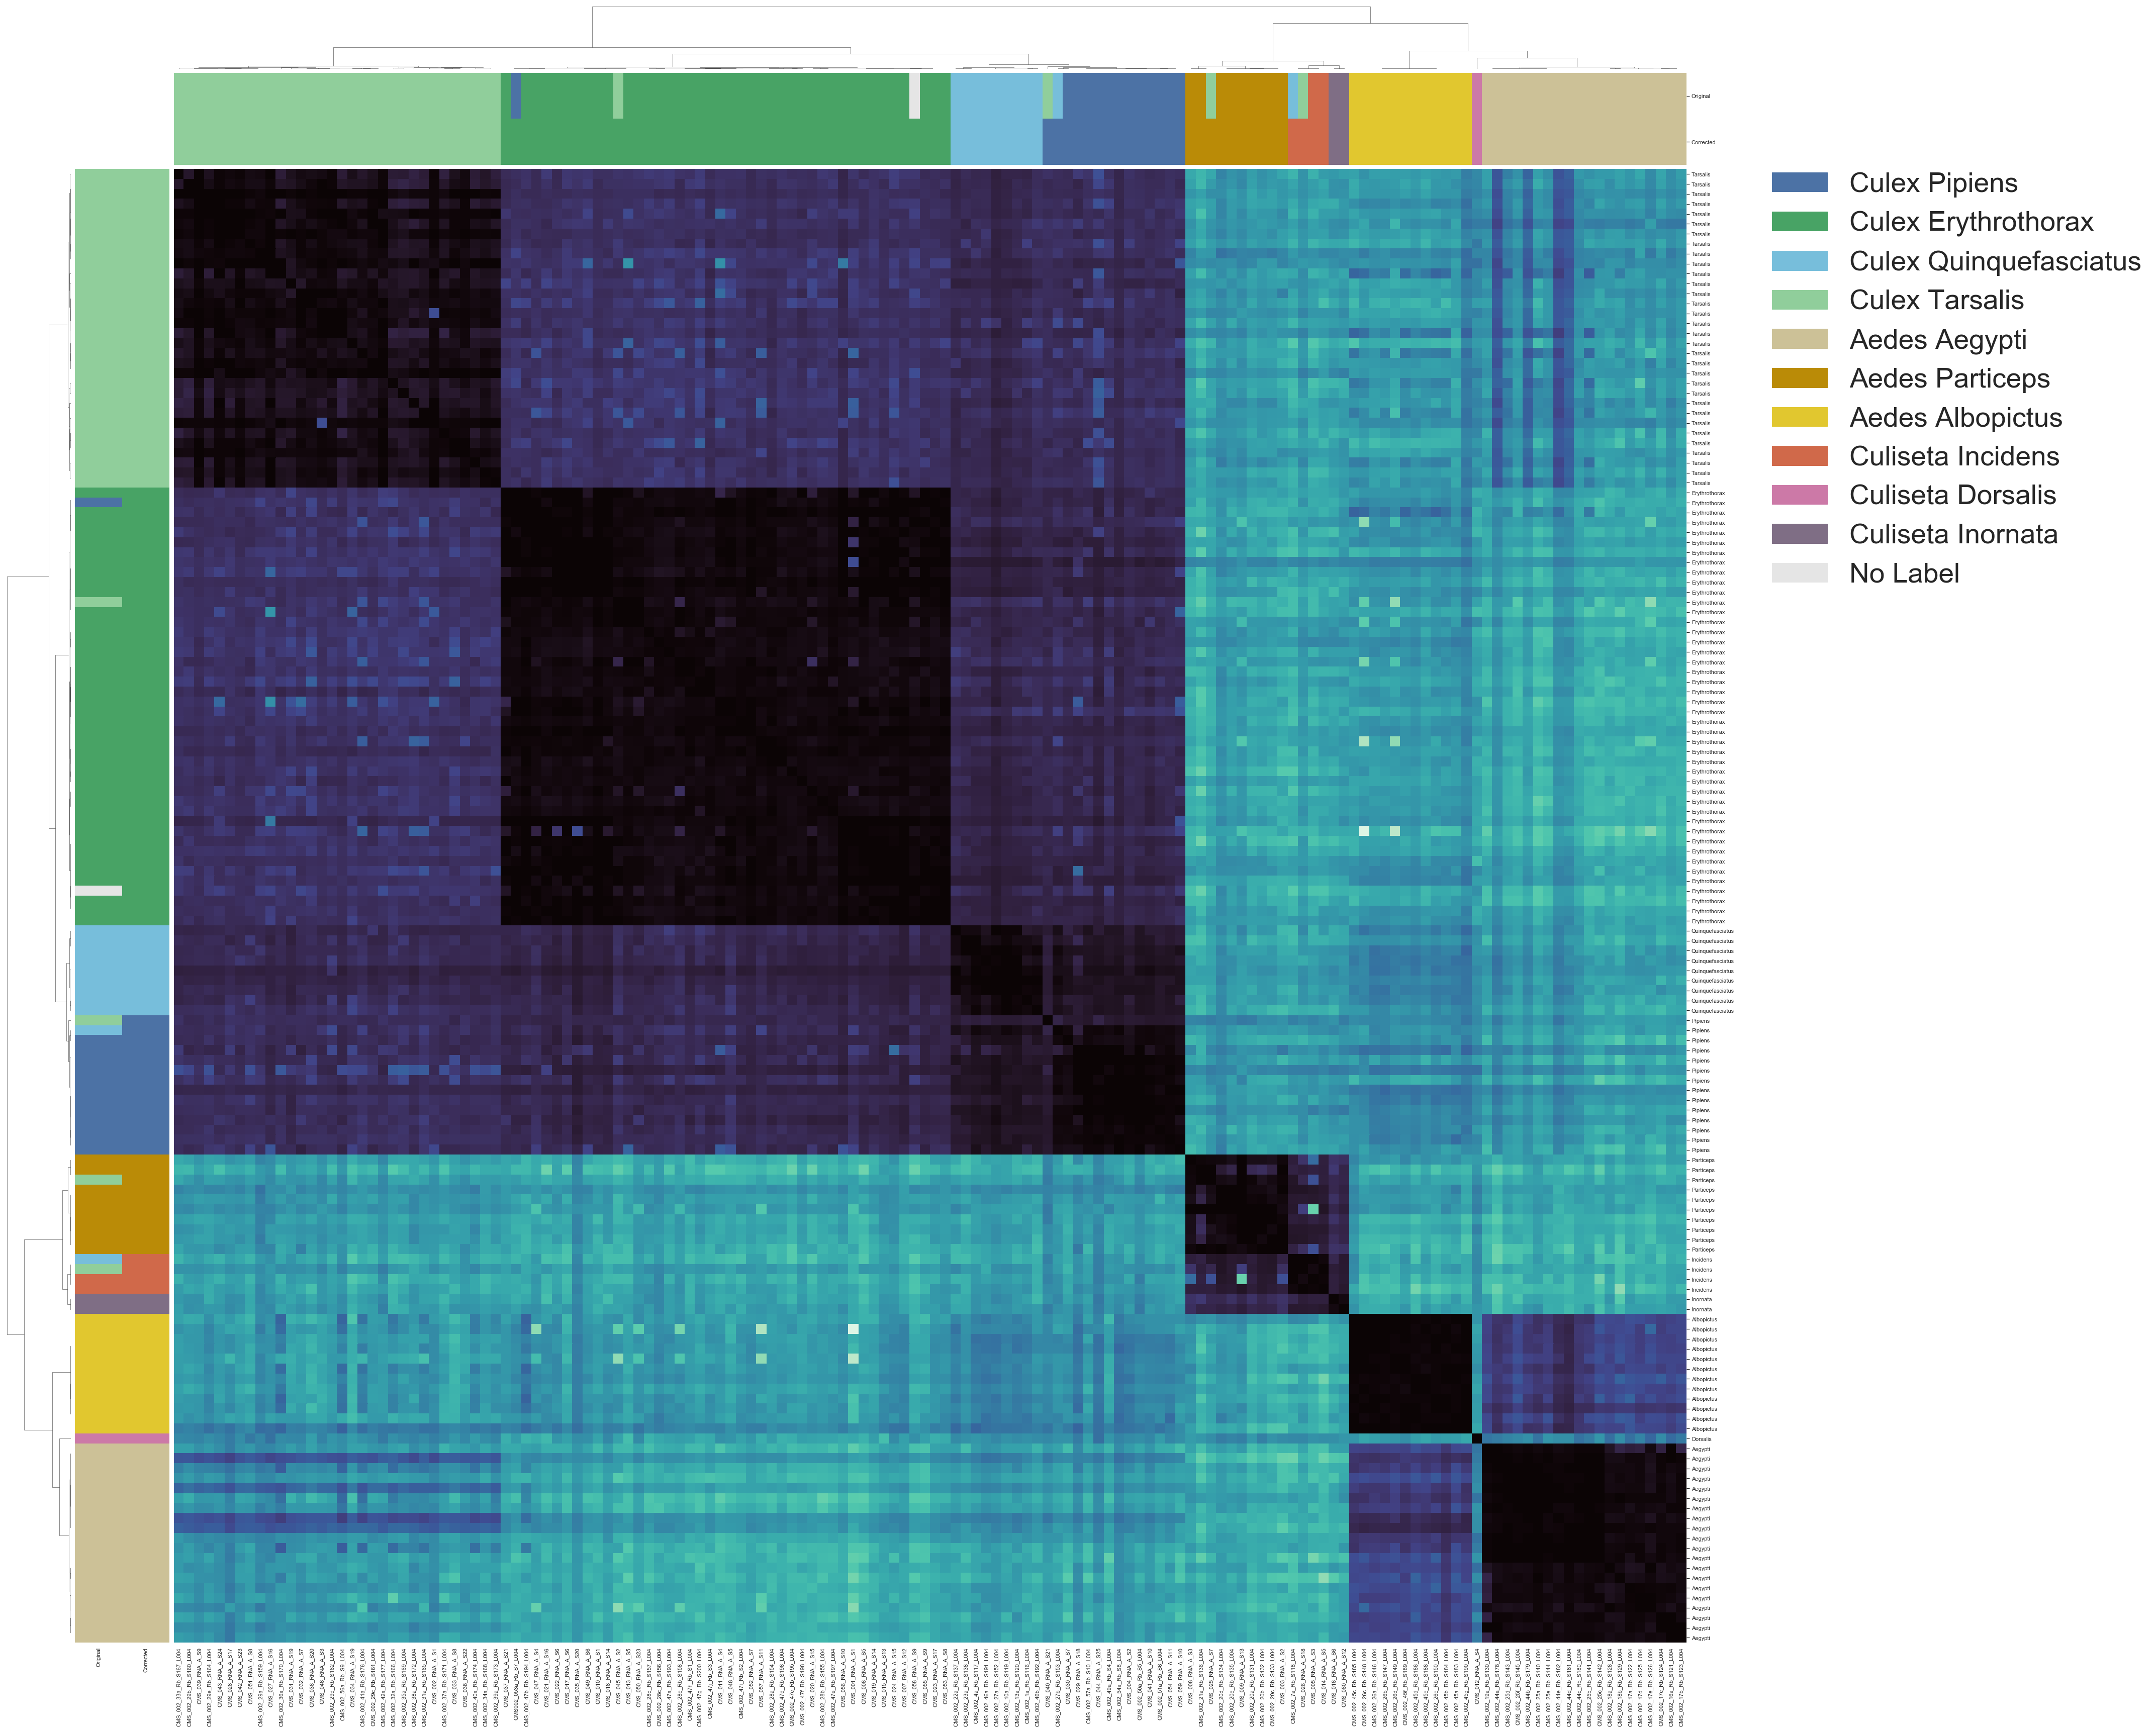

In [16]:
c, l = correlation_matrix(
    final_pivot_w_labels, 
    linkage, 
    cluster_map, 
    figsize=(60,60)
)

#return dd_pivot_w_ska_labels
final_pivot_w_labels.query(
    'visual_species != sourmash_species | ' + 
    'visual_species != ska_species | ' + 
    'sourmash_species != ska_species'
)


In [15]:
c.savefig("clustermap_species_assignment_clustermap.png", bbox_inches='tight')

In [17]:
final_table = final_pivot_w_labels.reset_index()[
    ["Sample_1", "visual_genus", "visual_species", "ska_genus", "ska_species"]
].rename(
    columns={
        "Sample_1": "Sample Name", 
        "visual_species": "Visual Species",
        "visual_genus": "Visual Genus",
        "ska_genus": "Corrected Genus",
        "ska_species": "Corrected Species"
    }
)

final_table.to_csv("visual_vs_corrected_species.csv", index=False)

final_pivot_w_labels.query(
    'visual_species != sourmash_species | ' + 
    'visual_species != ska_species | ' + 
    'sourmash_species != ska_species'
)

,,,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,visual_genus,visual_species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.001703,0.001656,0.006803,0.006993,0.007157,0.007046,0.007164,0.006995,...,0.002589,0.000000,0.000120,0.002081,0.000000,0.000000,0.000118,0.000000,0.002072,0.006644
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex,pipiens,0.002093,0.003095,0.000204,0.000407,0.006417,0.006431,0.006743,0.006680,0.006132,0.006680,...,0.002444,0.001779,0.001892,0.000281,0.001894,0.001622,0.003295,0.002487,0.000456,0.006027
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens,0.007397,0.007382,0.006635,0.007339,0.006987,0.007747,0.007251,0.007909,0.007351,0.006858,...,0.007307,0.006660,0.006268,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965,0.001193
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.006456,0.006506,0.006668,0.006927,0.007124,0.006571,0.006676,0.007206,0.006394,0.006822,...,0.006521,0.007105,0.006205,0.006219,0.007060,0.006616,0.006643,0.007341,0.006294,0.001839
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.006335,0.006193,0.006130,0.005832,0.006331,0.006283,0.006480,0.007073,0.006649,0.001227
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,pipiens,0.001785,0.001924,0.001294,0.001276,0.006369,0.006313,0.006213,0.006607,0.006405,0.006600,...,0.002311,0.001993,0.001779,0.001099,0.001800,0.001638,0.001809,0.001732,0.001243,0.005288
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.007349,0.008949,...,0.002869,0.000368,0.000000,0.002240,0.000126,0.000250,0.000353,0.000867,0.002364,0.006753
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.007182,0.007557,0.007459,0.007599,0.006926,...,0.002230,0.000114,0.000000,0.002041,0.000238,0.000000,0.000343,0.000000,0.002843,0.007224
CMS_060_RNA_A_S12,Culiseta,inornata,NaN,NaN,Culiseta,inornata,0.006644,0.006867,0.006045,0.006452,0.006558,0.006552,0.006335,0.006715,0.006531,0.006565,...,0.006895,0.006281,0.006073,0.006577,0.006543,0.005882,0.006141,0.007224,0.006298,0.000000


silhouette score:  SNP Distance 0.8156907760583931


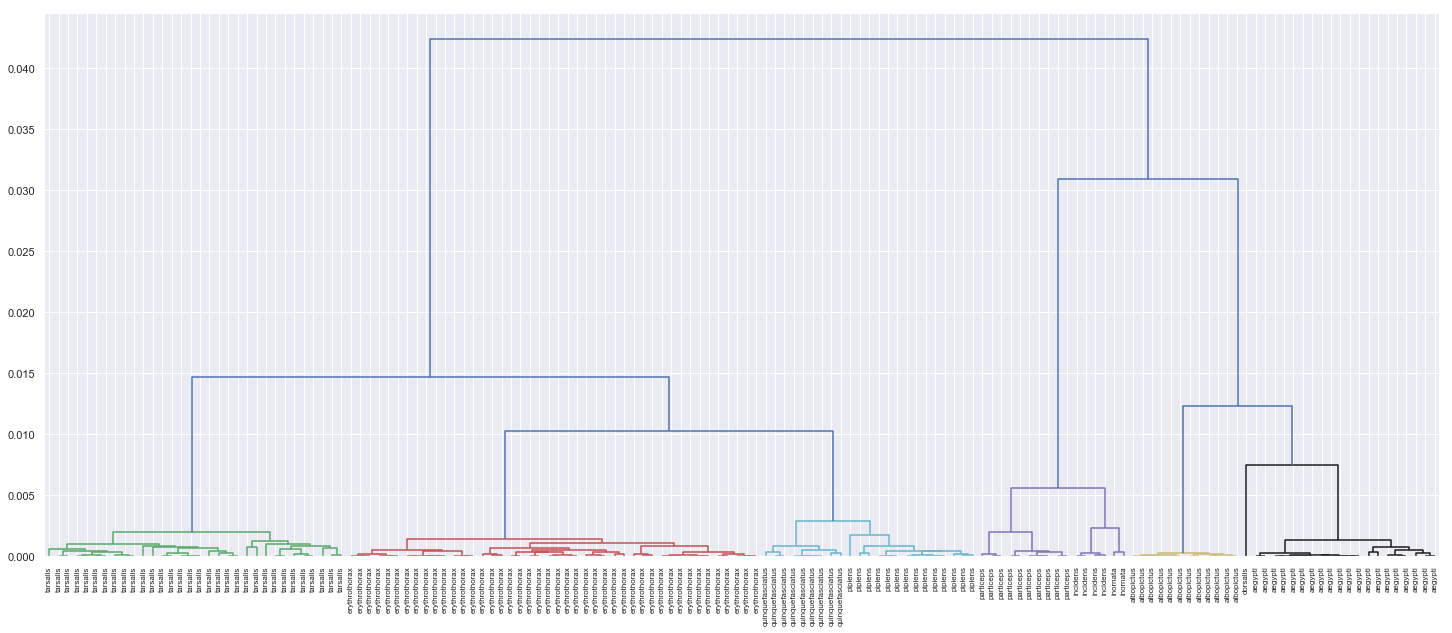

In [18]:
# Silhouette scores comparing clustering with mash-like distance and snp distance

silhouette_snp = get_silhouette_score(
    final_pivot_w_labels,
    species_id,
    "_ksize_15",
    values="SNP_distance"
)

print(
    "silhouette score: ",
    f"SNP Distance {silhouette_snp}", 
)

dn = hierarchical_clustering(
    final_pivot_w_labels, 
    species_id,
    "_ksize_15", 
    10, 
    values="SNP_distance"
)
